# UMAP with CellProfiler features

Previous UMAPs of CellProfiler data just created giant blobs. The Cytoself embeddings have detailed structure in the UMAP. We think that it was the new representation itself that gives this structure, but it's possible that it was also the agressive filtering that we did. Here we read in the exact list of cells that were used to compute the Cytoself UMAP and compute a UMAP with the processed CellProfiler features for these cells.

Overall findings: CellProfiler features do show some structure wrt localization (esp when looking at GFP only), but it is not nearly as consistent as the DL features. For example, there are many small islands that are not clearly related to distinct protein localization as a small percentage of cells from nearly every allele fall into these islands. In contrast, the Cytoself embeddings do show that different "islands" actually have super consistent membership from distinct alleles. 

In [31]:
# Images
import polars as pl
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

In [1]:
# Paths
umap_labels = "/dgx1nas1/storage/data/jess/cytoself/trained_models/varchamp_v1/embeddings/labels_testdata.npy"
profiles = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet"

In [9]:
# Get cell IDs
cells = list(np.load(umap_labels, allow_pickle=True)[:,1])

In [14]:
# Get profiles
dat = pl.scan_parquet(profiles).with_columns(
    pl.concat_str(
        ['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber', 'Metadata_ObjectNumber'],
        separator="_").alias("Metadata_CellID"))

dat = dat.filter(pl.col("Metadata_CellID").is_in(cells)).collect()

In [20]:
# Get different feature groups
feat_cols = [i for i in dat.columns if "Metadata_" not in i]
meta_cols = [i for i in dat.columns if "Metadata_" in i]
gfp_cols =  [
                i
                for i in feat_cols
                if ("GFP" in i)
                and ("DNA" not in i)
                and ("AGP" not in i)
                and ("Mito" not in i)
                and ("Brightfield" not in i)
            ]
gd_cols =   [
                i
                for i in feat_cols
                if ("GFP" in i)
                or ("DNA" in i)
                and ("AGP" not in i)
                and ("Mito" not in i)
                and ("Brightfield" not in i)
            ]


In [ ]:
# Plotnine imports
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle, scale_color_manual, geom_text
import plotnine as plotnine
plotnine.options.figure_size = (16,16)

In [23]:
# Compute UMAP
n_neighbors=15
min_dist=0.1
metric='euclidean'
verbose=True

reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, verbose=verbose)


In [24]:
# All CP features
umap_data = reducer.fit_transform(dat.select(feat_cols))
umap_all = pl.DataFrame(
    {
        "Comp1": umap_data[:,0],
        "Comp2": umap_data[:,1]
    }
)
umap_all = pl.concat([dat.select(meta_cols), umap_all], how = "horizontal")

UMAP( verbose=True)
Thu Jul 25 14:28:34 2024 Construct fuzzy simplicial set
Thu Jul 25 14:28:34 2024 Finding Nearest Neighbors
Thu Jul 25 14:28:34 2024 Building RP forest with 18 trees
Thu Jul 25 14:28:37 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	Stopping threshold met -- exiting after 7 iterations
Thu Jul 25 14:28:41 2024 Finished Nearest Neighbor Search
Thu Jul 25 14:28:41 2024 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:43]


Thu Jul 25 14:29:30 2024 Finished embedding


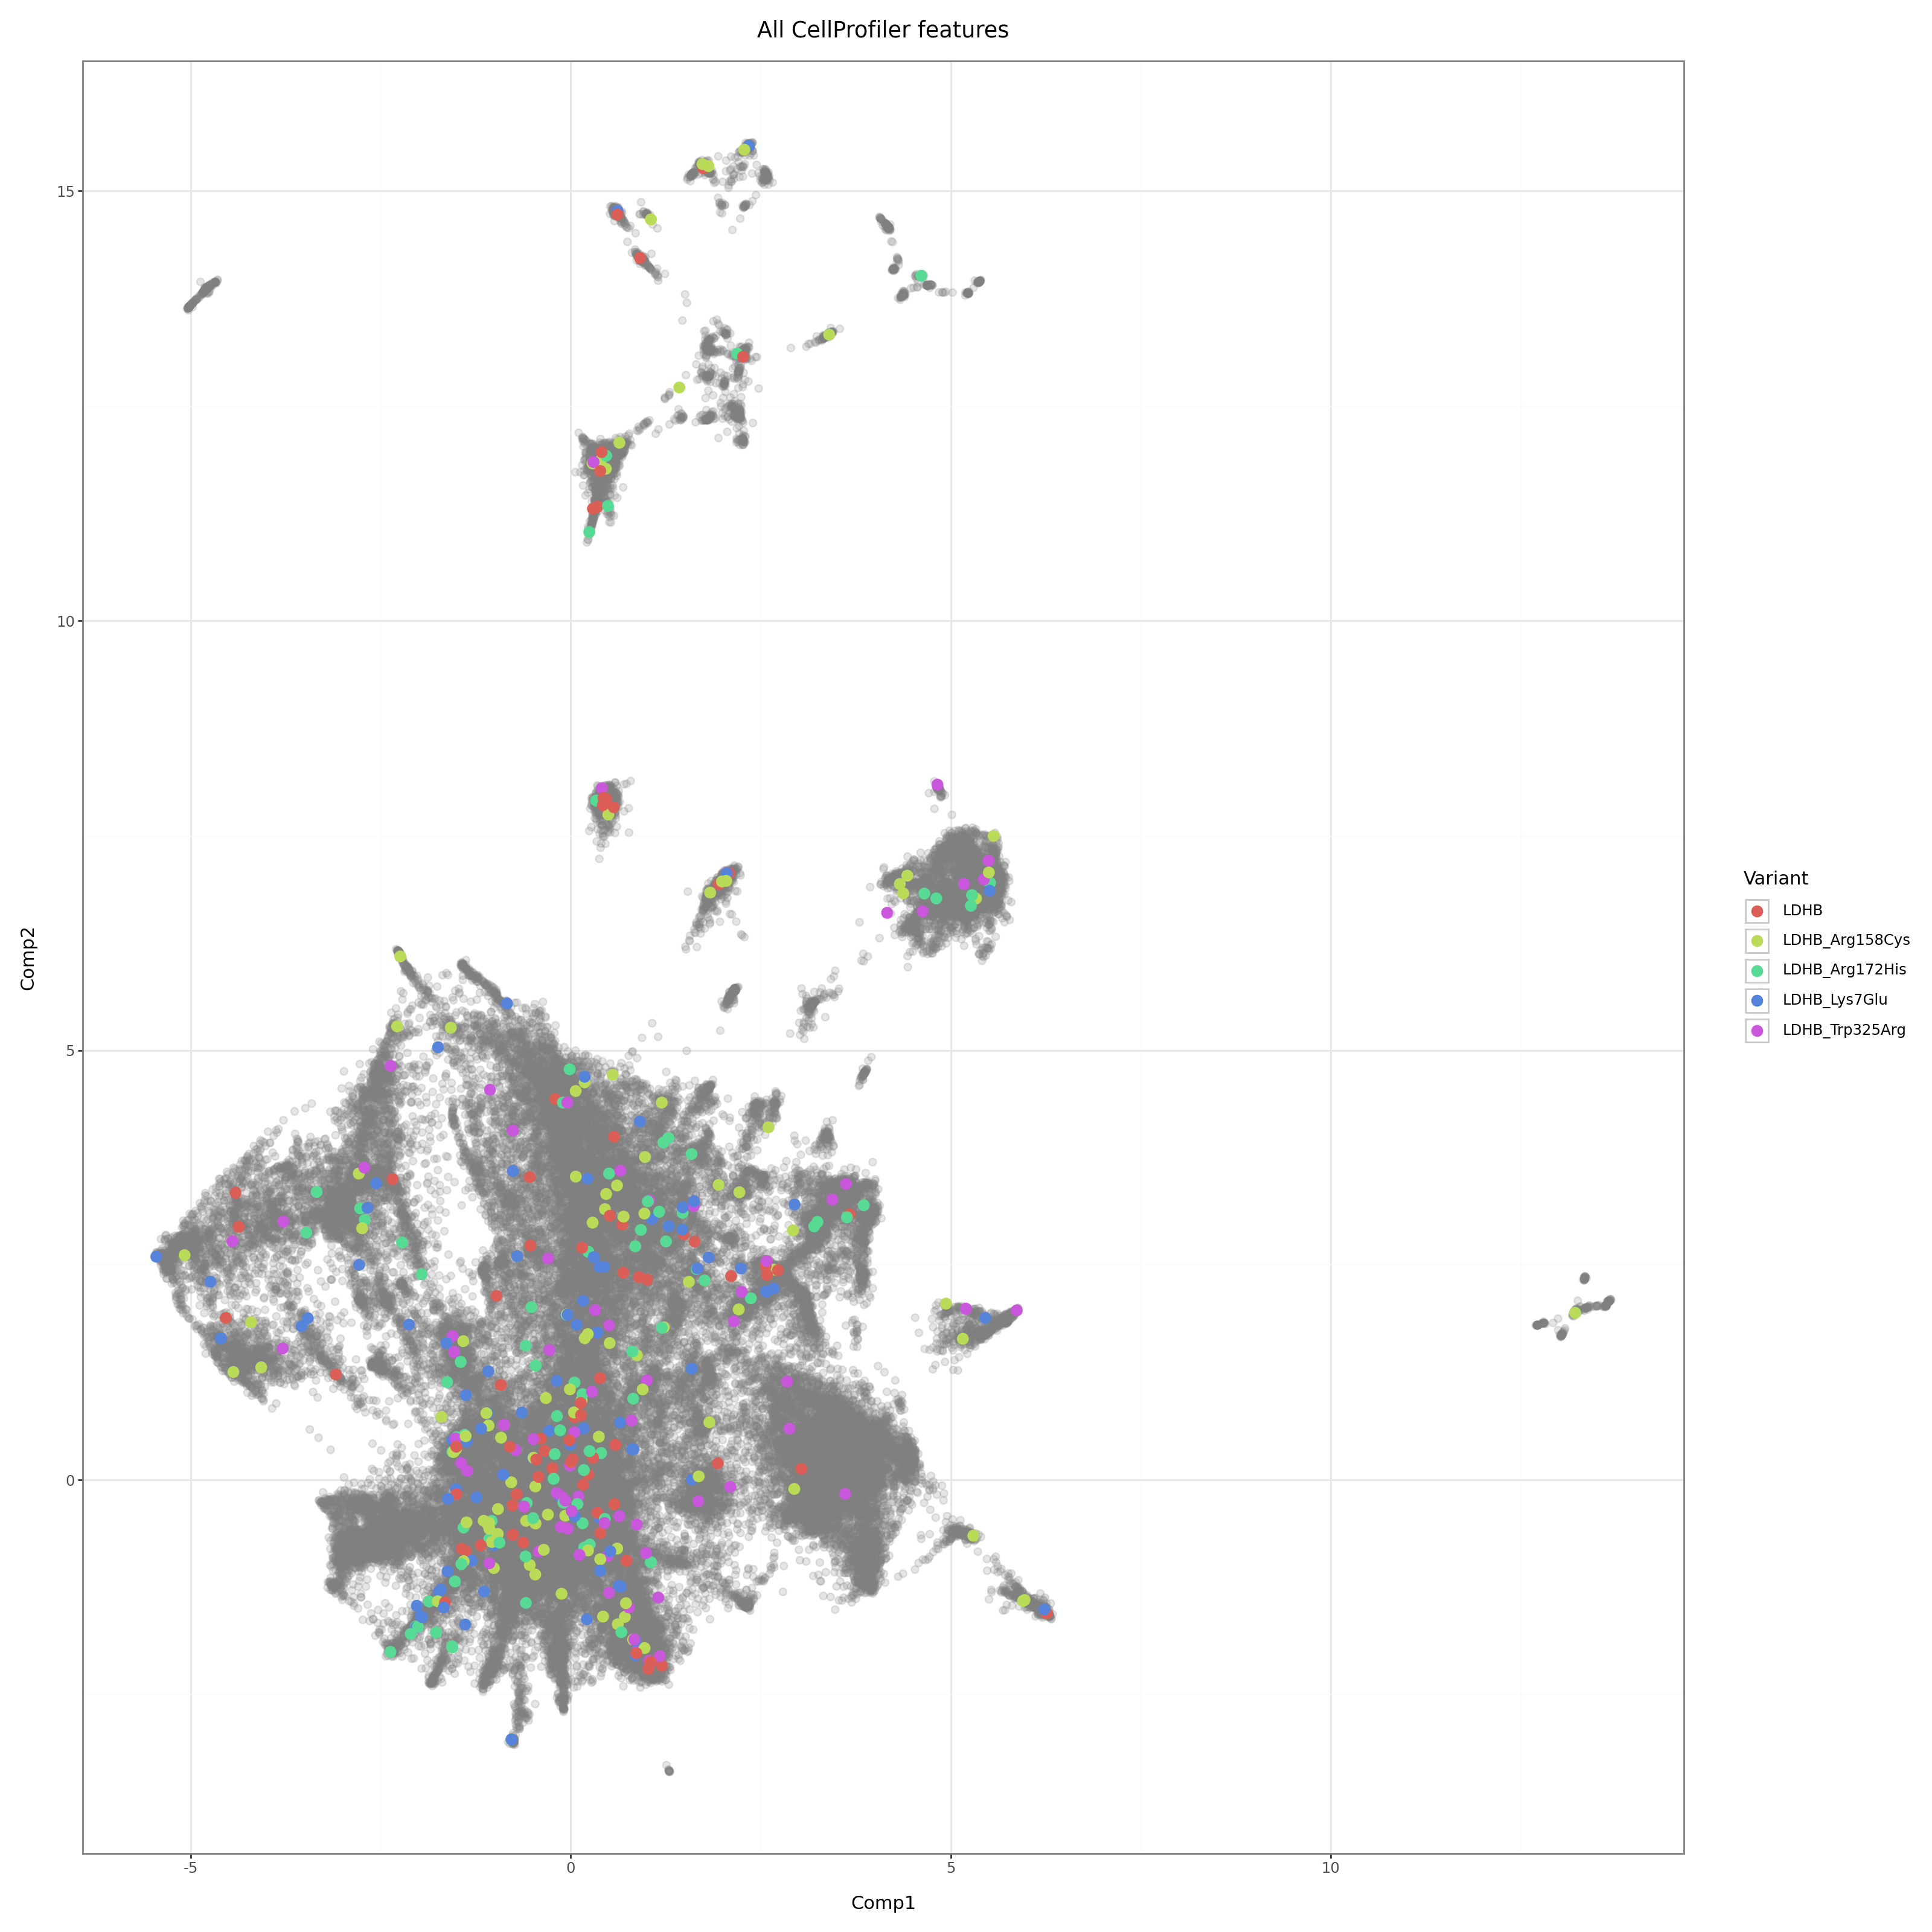

In [36]:
gene = "LDHB"
umap_all = umap_all.with_columns(
    pl.when(pl.col("Metadata_gene_allele").str.contains(gene))
    .then(pl.col("Metadata_gene_allele"))
    .otherwise(pl.lit("000")).alias("Variant")
).sort("Variant")

p = (ggplot() +
    geom_point(umap_all.filter(pl.col("Variant") == "000"), aes(x = "Comp1", y = "Comp2"), color='grey',size=2, alpha=0.2) +
        geom_point(umap_all.filter(pl.col("Variant") != "000").sample(fraction=1.0, shuffle=True), aes(x = "Comp1", y = "Comp2", color='Variant'), size=3) +
    theme_bw() + ggtitle("All CellProfiler features")
    )
p.show()

In [ ]:
# All CP features and standard scaler
umap_data = reducer.fit_transform(StandardScaler().fit_transform(dat.select(feat_cols)))

umap_ss = pl.DataFrame(
    {
        "Comp1": umap_data[:,0],
        "Comp2": umap_data[:,1]
    }
)
umap_ss = pl.concat([dat.select(meta_cols), umap_ss], how = "horizontal")

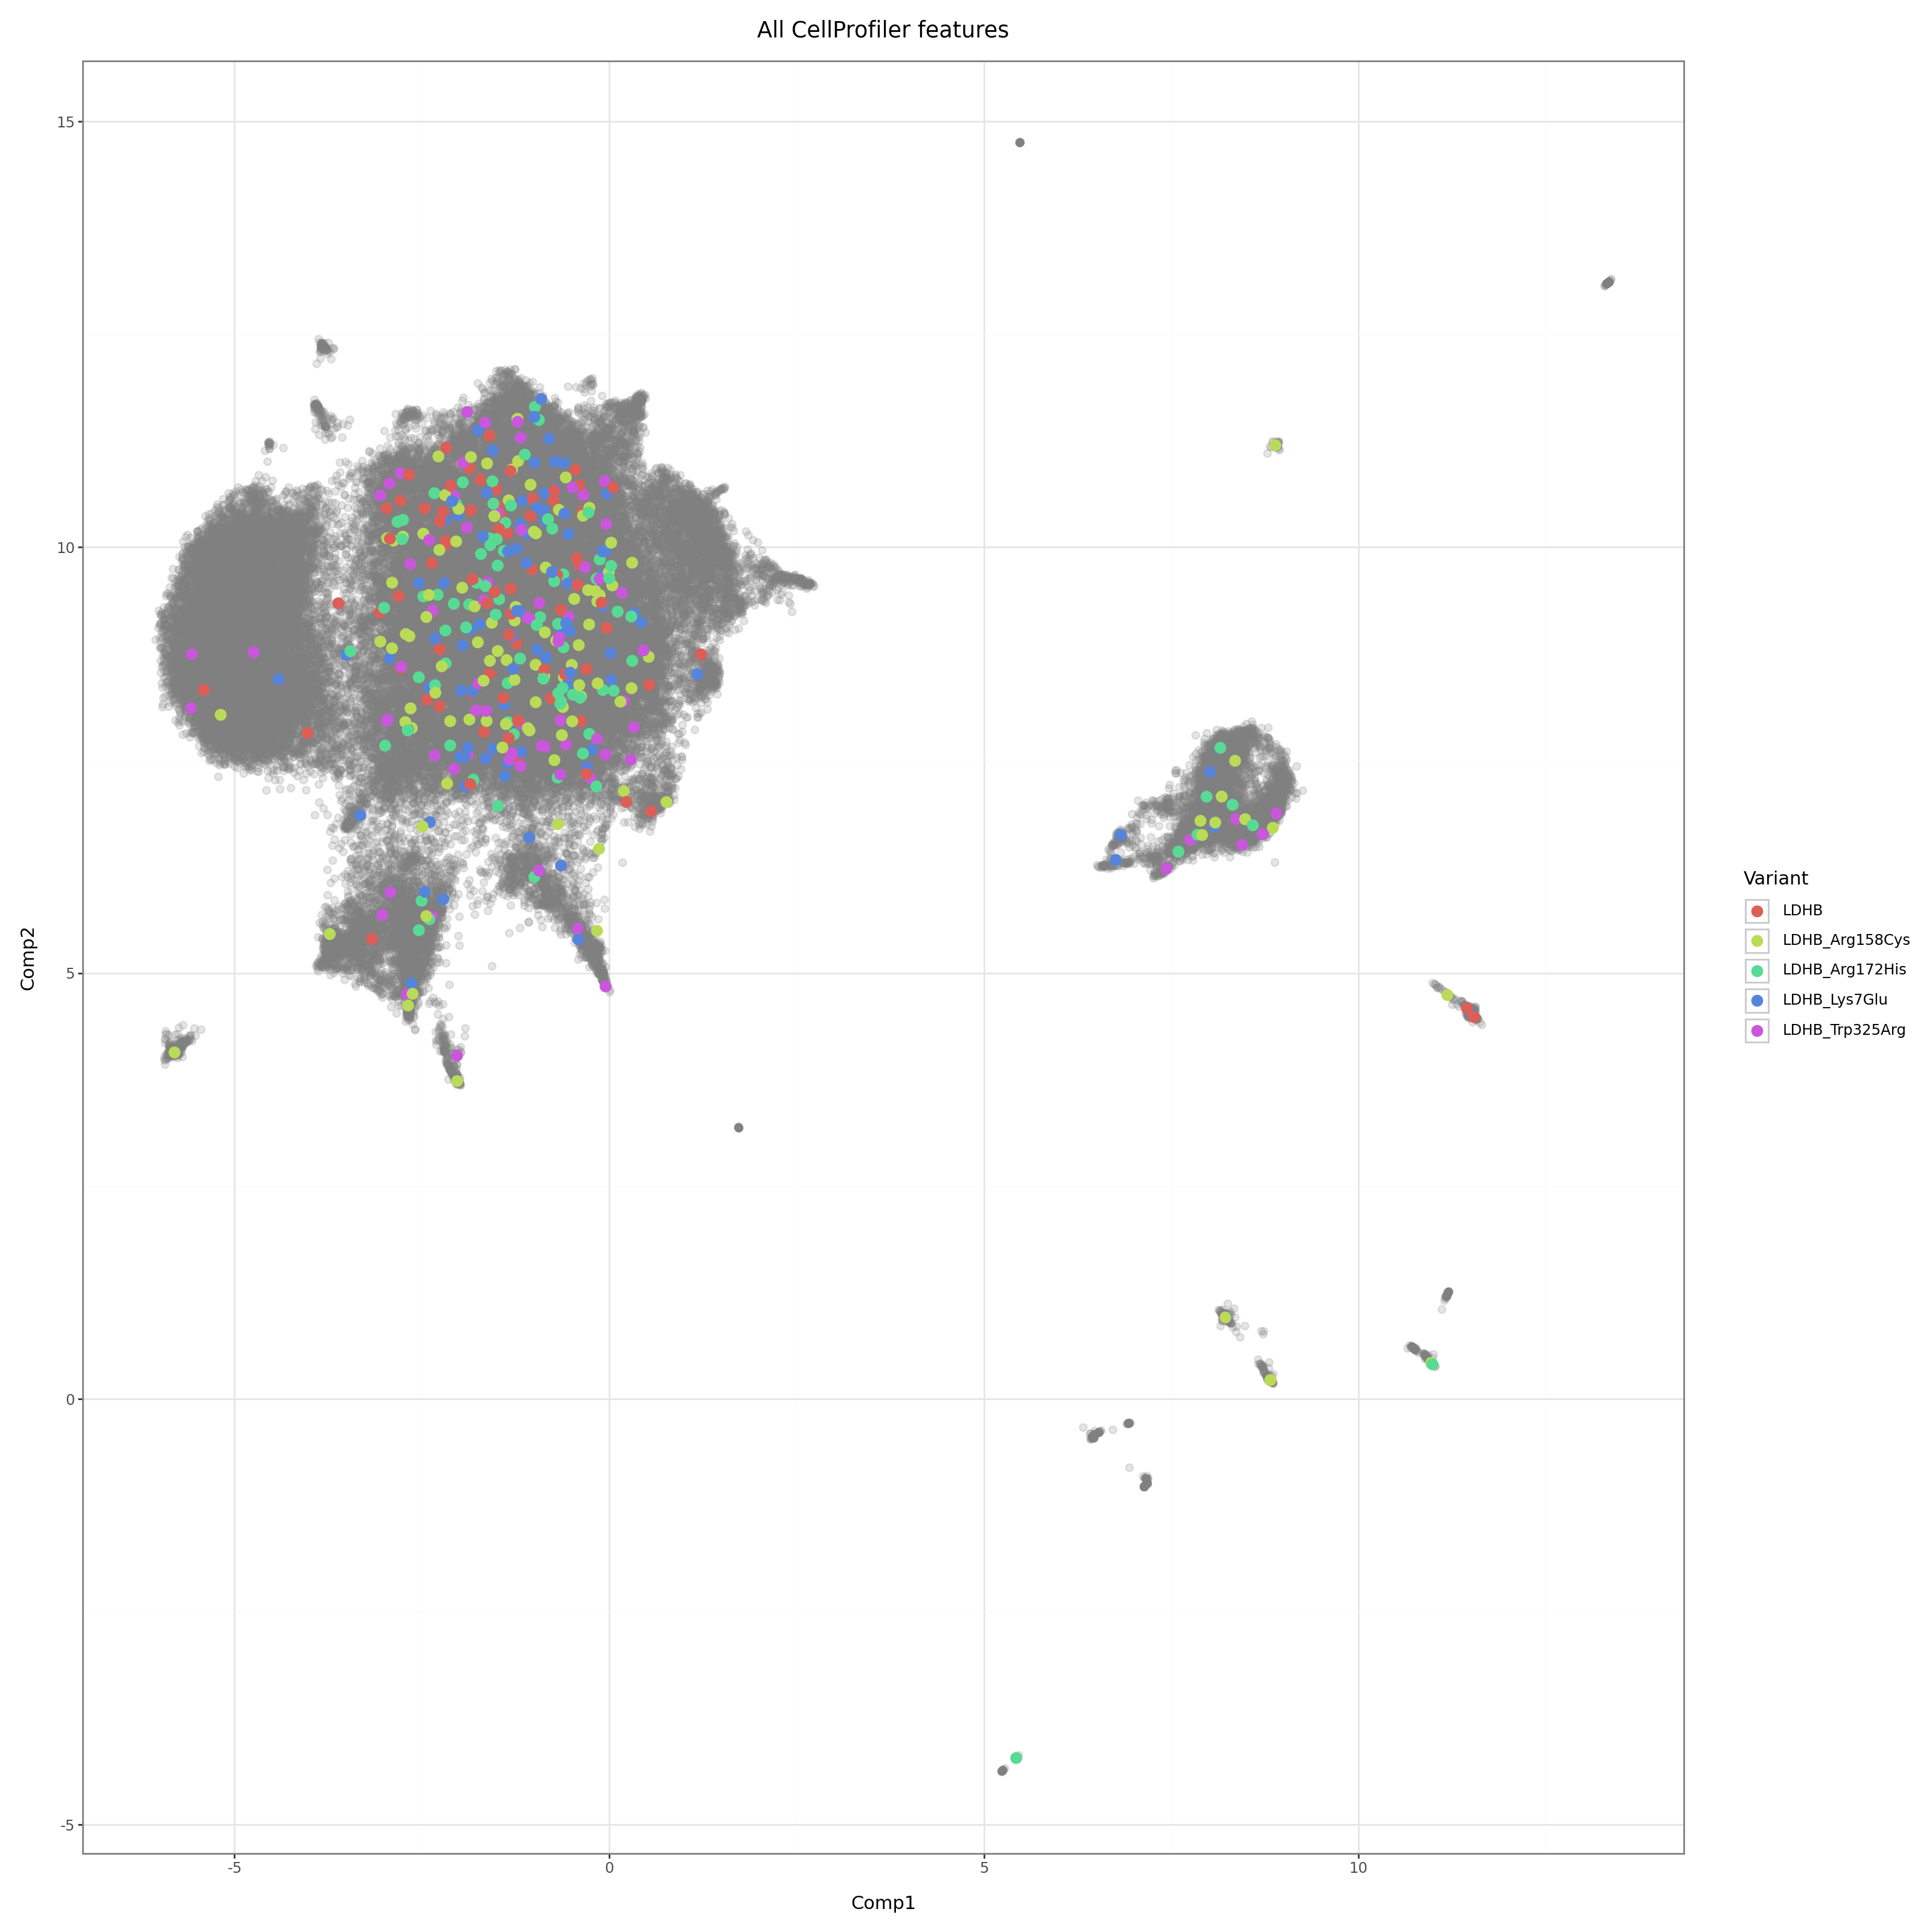

In [35]:

gene = "LDHB"
umap_ss = umap_ss.with_columns(
    pl.when(pl.col("Metadata_gene_allele").str.contains(gene))
    .then(pl.col("Metadata_gene_allele"))
    .otherwise(pl.lit("000")).alias("Variant")
).sort("Variant")

p = (ggplot() +
    geom_point(umap_ss.filter(pl.col("Variant") == "000"), aes(x = "Comp1", y = "Comp2"), color='grey',size=2, alpha=0.2) +
    geom_point(umap_ss.filter(pl.col("Variant") != "000").sample(fraction=1.0, shuffle=True), aes(x = "Comp1", y = "Comp2", color='Variant'), size=3) +
    theme_bw() + ggtitle("All CellProfiler features")
    )

p.show()

In [27]:
# GFP and DAPI
umap_data = reducer.fit_transform(dat.select(gd_cols))
umap_gd = pl.DataFrame(
    {
        "Comp1": umap_data[:,0],
        "Comp2": umap_data[:,1]
    }
)
umap_gd = pl.concat([dat.select(meta_cols), umap_gd], how = "horizontal")

UMAP( verbose=True)
Thu Jul 25 14:30:54 2024 Construct fuzzy simplicial set
Thu Jul 25 14:30:54 2024 Finding Nearest Neighbors
Thu Jul 25 14:30:54 2024 Building RP forest with 18 trees
Thu Jul 25 14:30:54 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Thu Jul 25 14:30:58 2024 Finished Nearest Neighbor Search
Thu Jul 25 14:30:58 2024 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:43]

Thu Jul 25 14:31:45 2024 Finished embedding


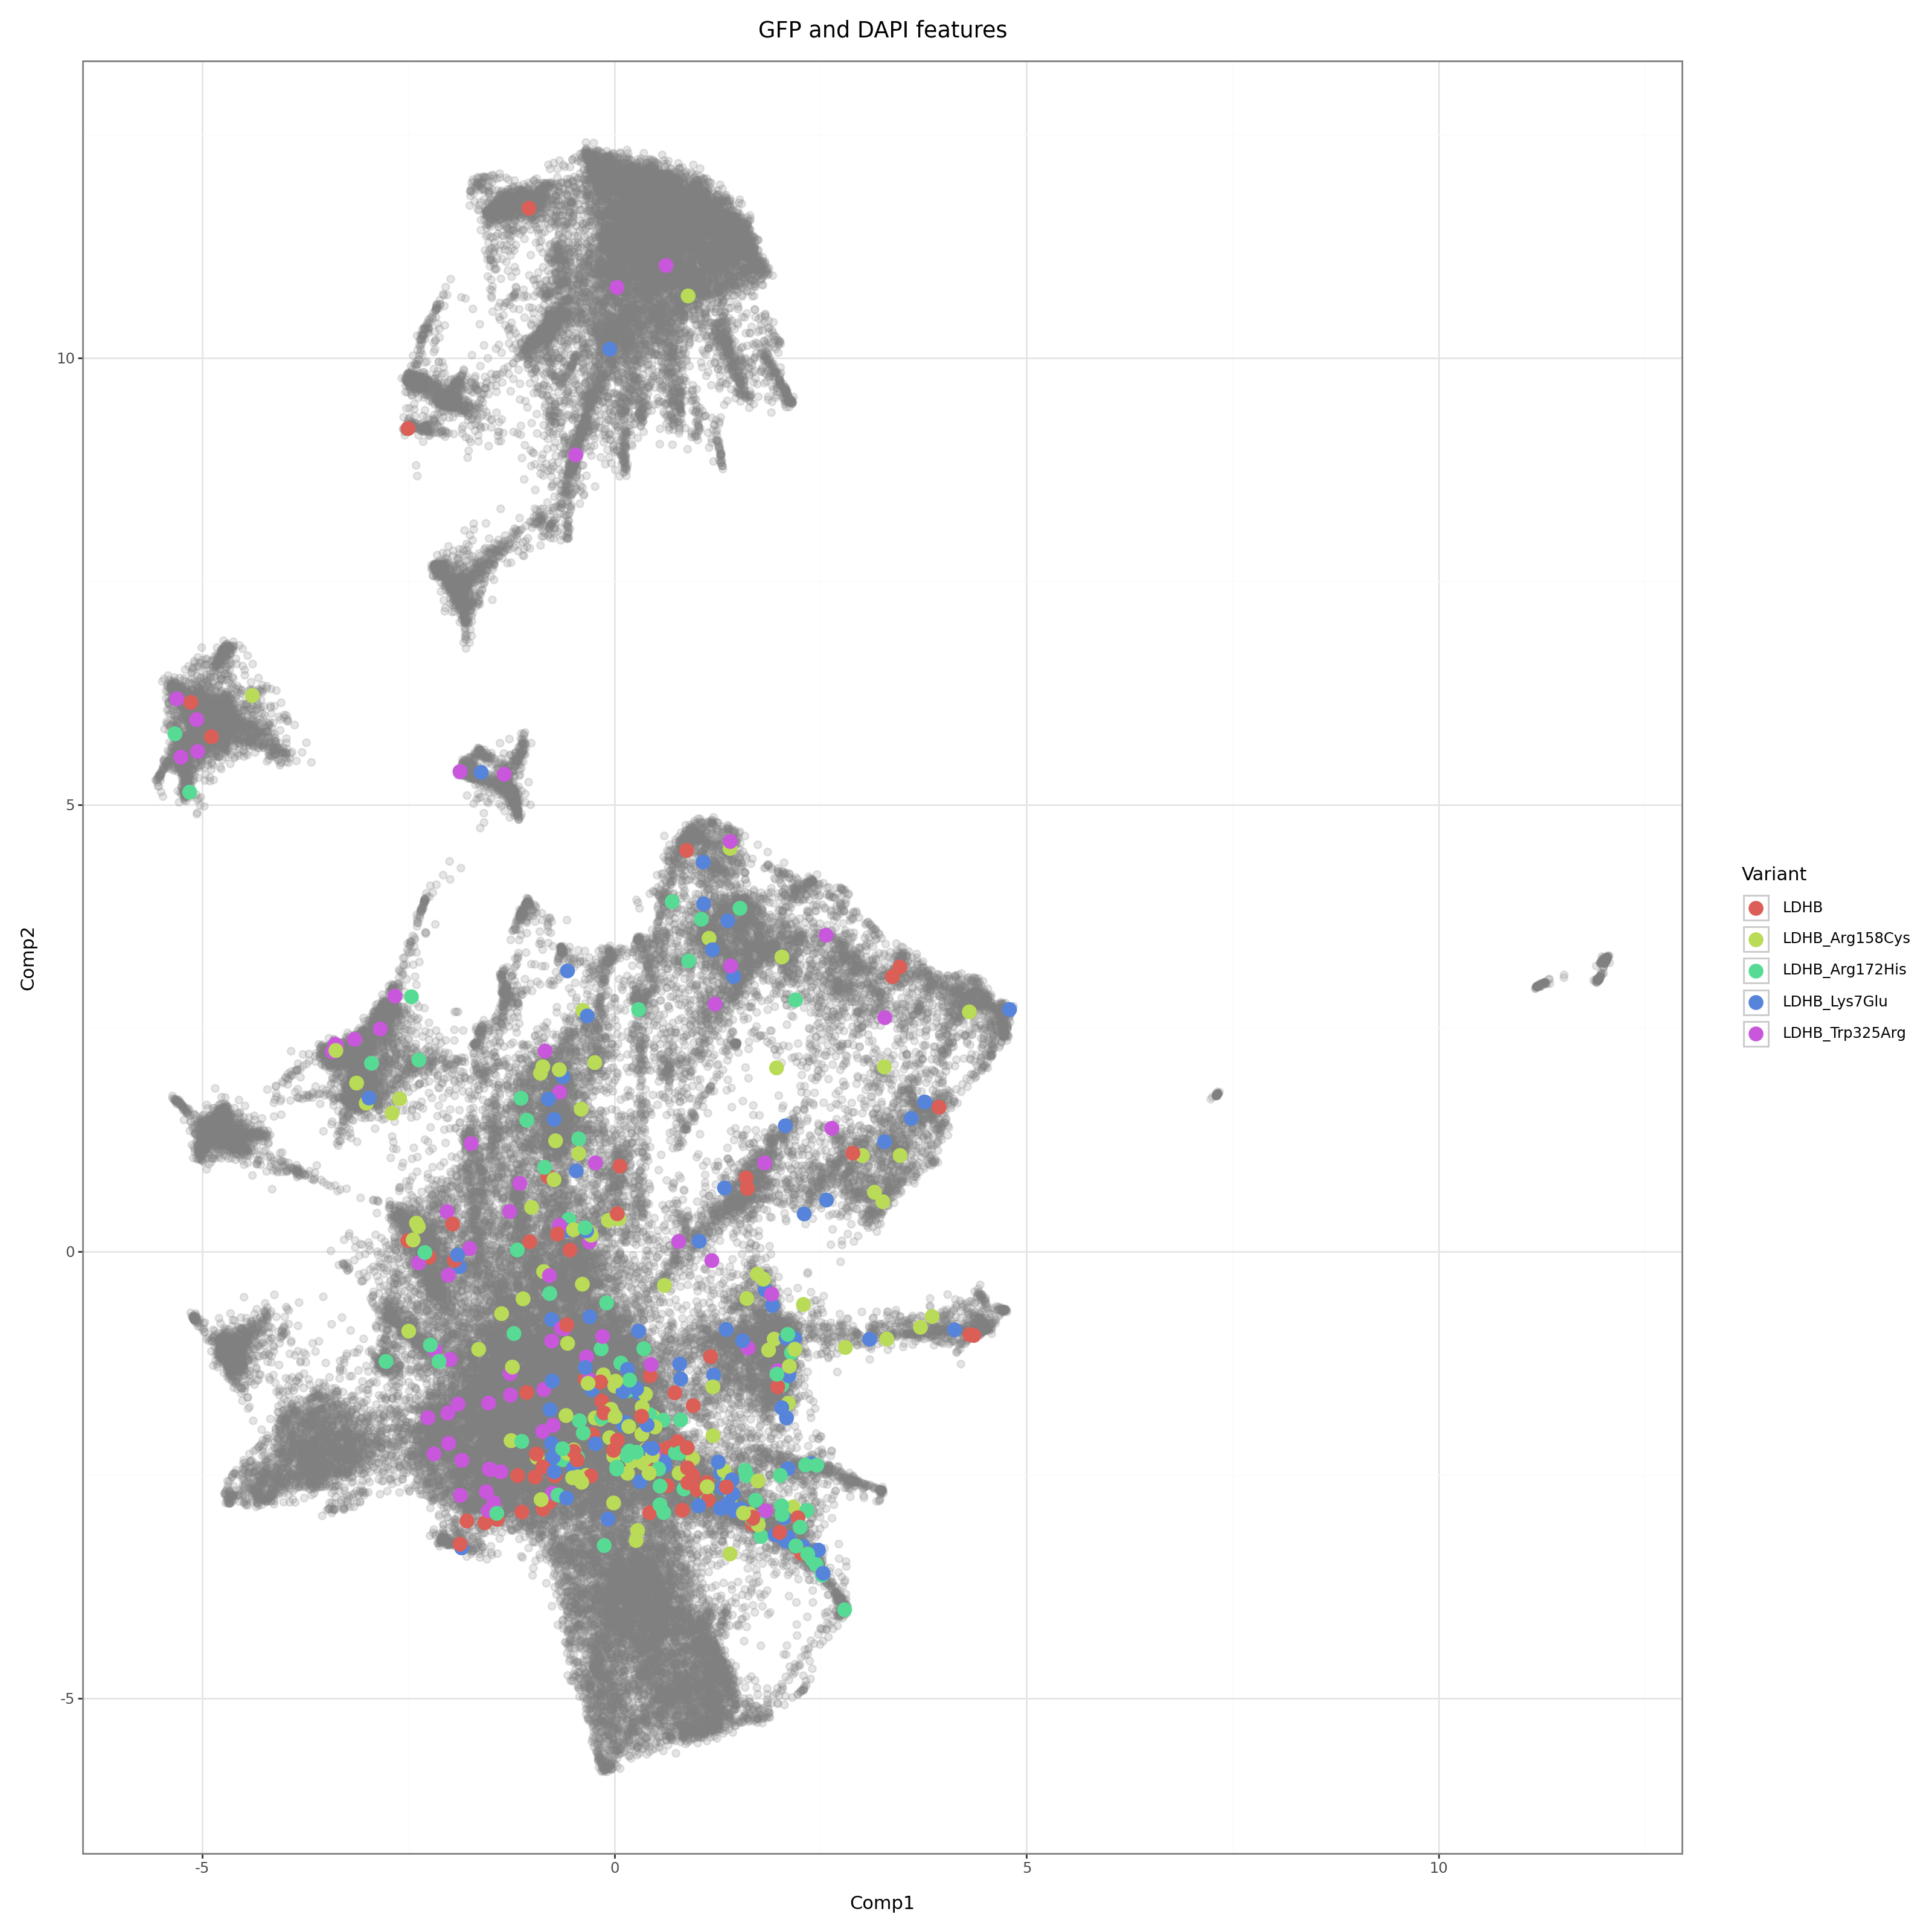

In [33]:
gene = "LDHB"
umap_gd = umap_gd.with_columns(
    pl.when(pl.col("Metadata_gene_allele").str.contains(gene))
    .then(pl.col("Metadata_gene_allele"))
    .otherwise(pl.lit("000")).alias("Variant")
).sort("Variant")

p = (ggplot() +
    geom_point(umap_gd.filter(pl.col("Variant") == "000"), aes(x = "Comp1", y = "Comp2"), color='grey',size=2, alpha=0.2) +
    geom_point(umap_gd.filter(pl.col("Variant") != "000").sample(fraction=1.0, shuffle=True), aes(x = "Comp1", y = "Comp2", color='Variant'), size=4) +
    theme_bw() + ggtitle("GFP and DAPI features")
    )
p.show()

In [29]:
# GFP only
umap_data = reducer.fit_transform(dat.select(gfp_cols))
umap_gfp = pl.DataFrame(
    {
        "Comp1": umap_data[:,0],
        "Comp2": umap_data[:,1]
    }
)
umap_gfp = pl.concat([dat.select(meta_cols), umap_gfp], how = "horizontal")

UMAP( verbose=True)
Thu Jul 25 14:32:51 2024 Construct fuzzy simplicial set
Thu Jul 25 14:32:51 2024 Finding Nearest Neighbors
Thu Jul 25 14:32:51 2024 Building RP forest with 18 trees
Thu Jul 25 14:32:52 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Thu Jul 25 14:32:55 2024 Finished Nearest Neighbor Search
Thu Jul 25 14:32:55 2024 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:34]


Thu Jul 25 14:33:36 2024 Finished embedding


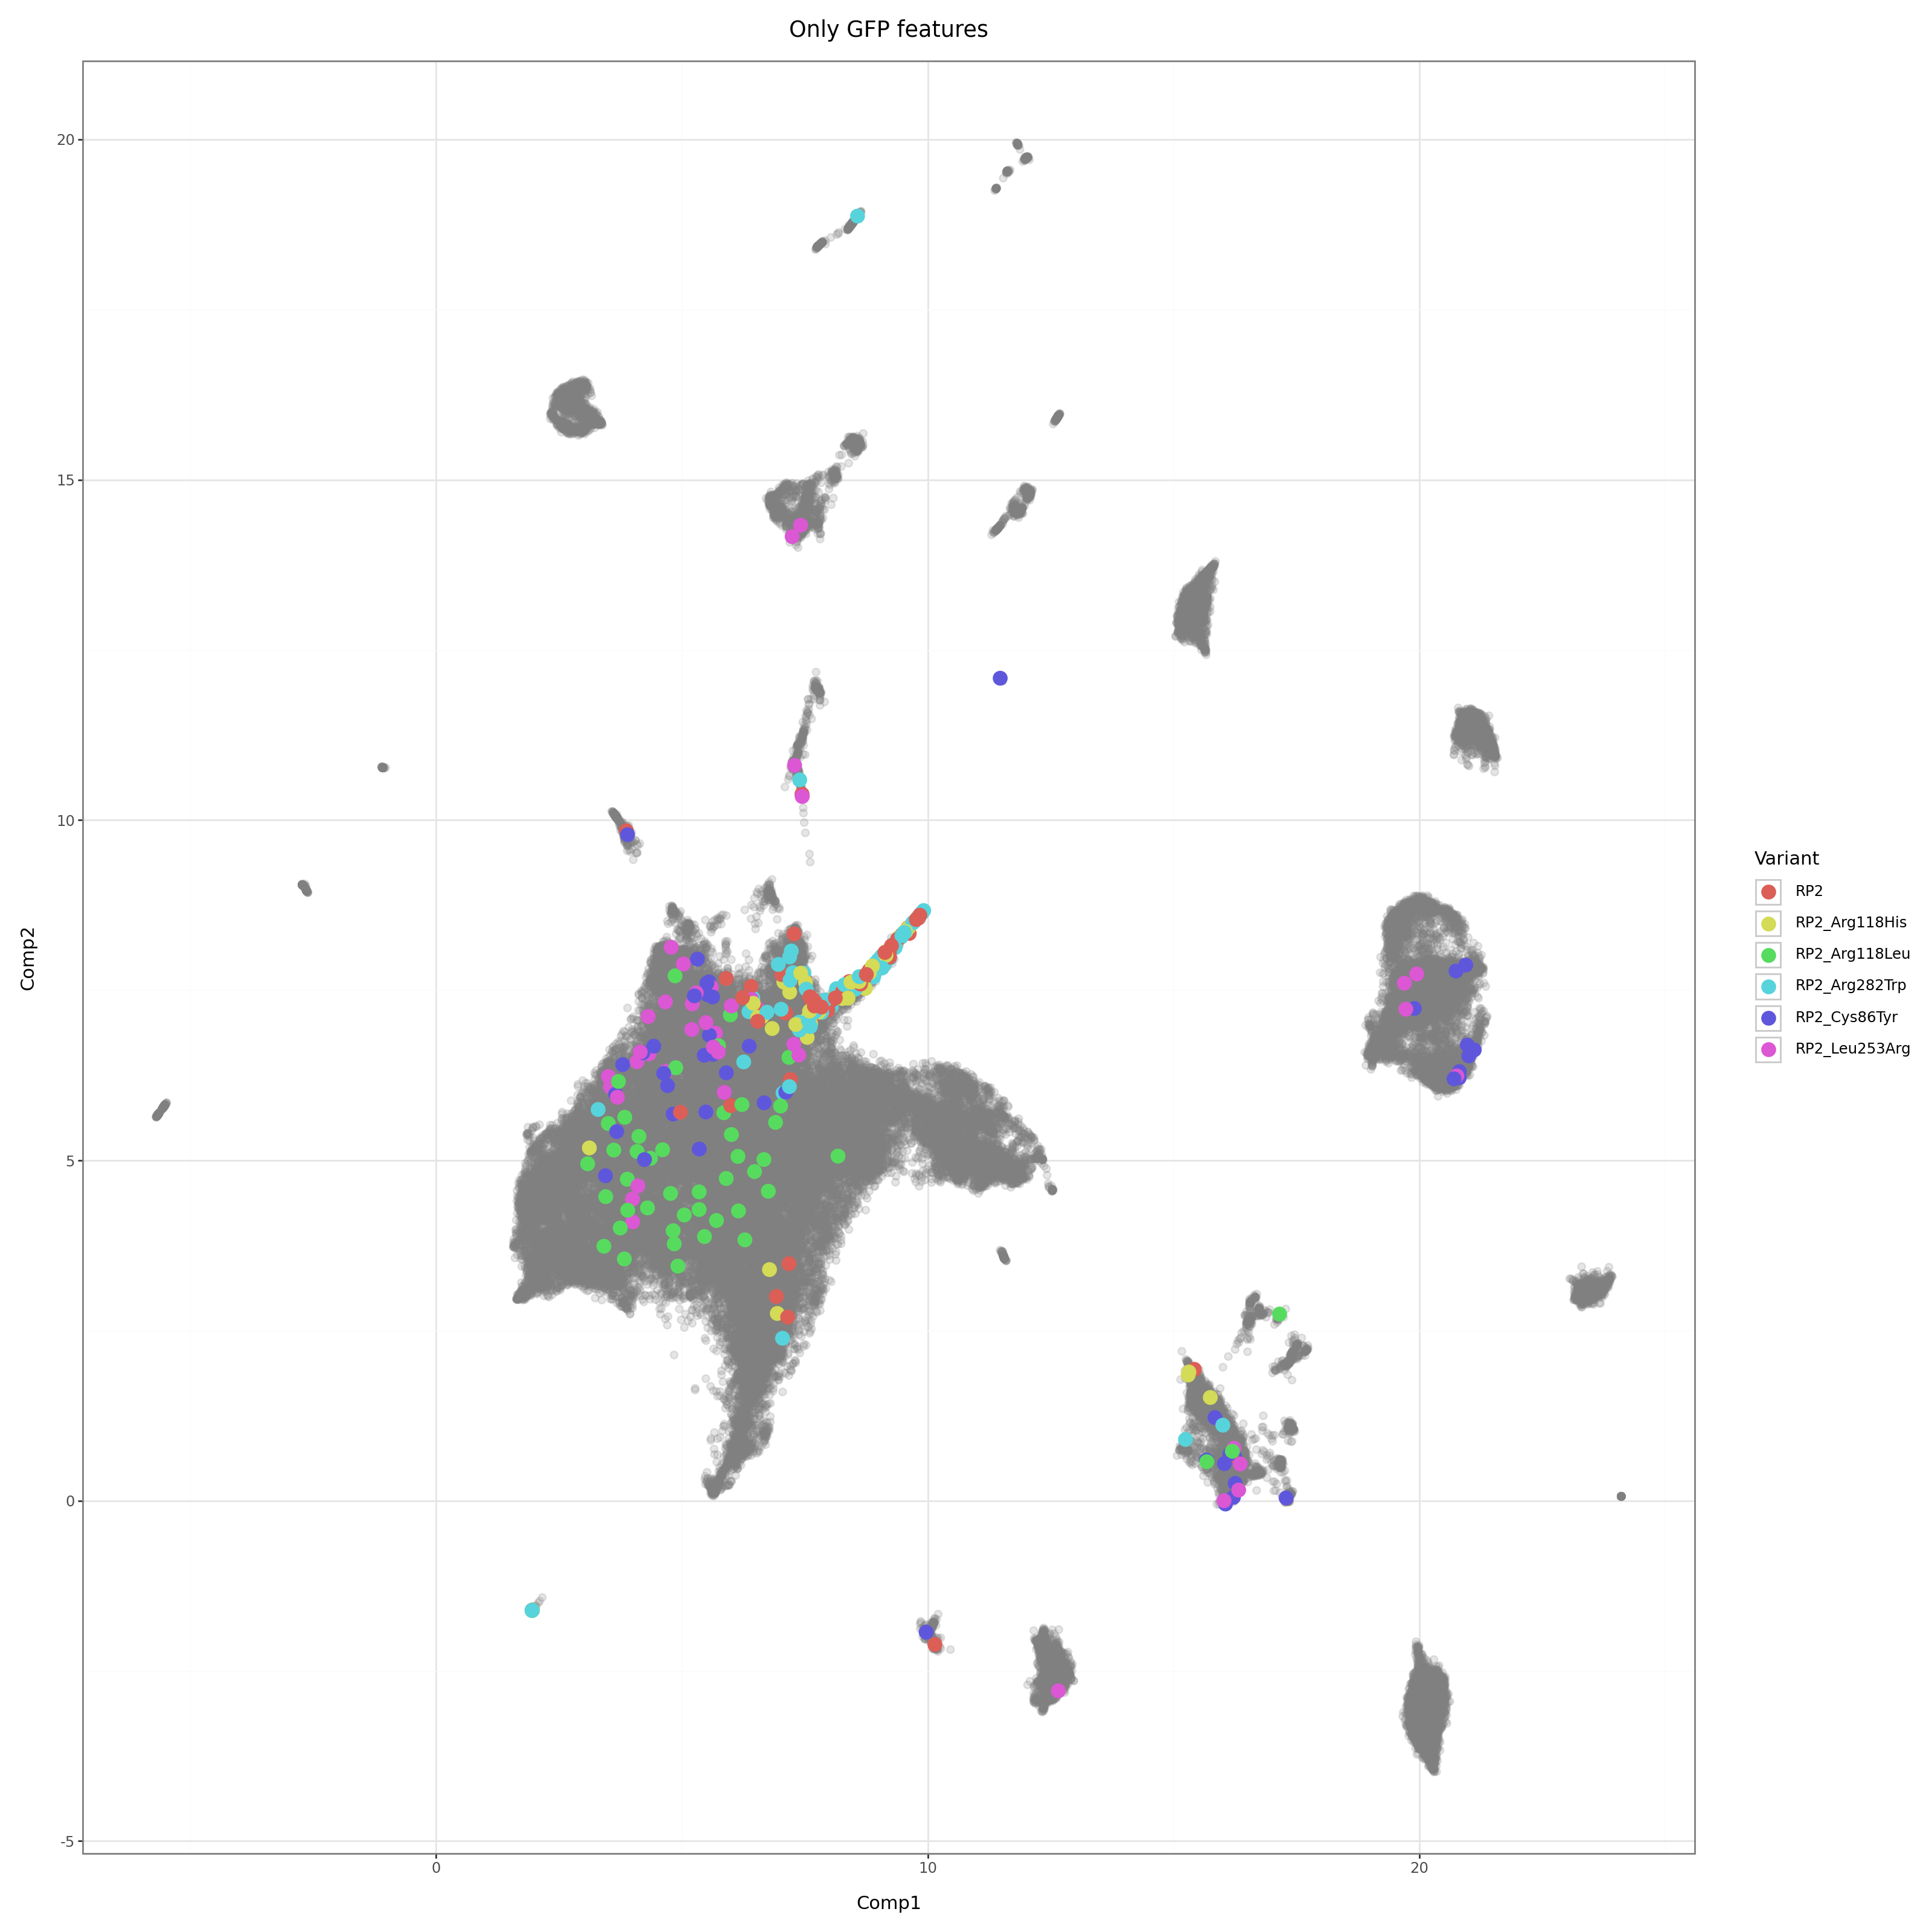

In [38]:
gene = "RP2"
umap_gfp = umap_gfp.with_columns(
    pl.when(pl.col("Metadata_gene_allele").str.contains(gene))
    .then(pl.col("Metadata_gene_allele"))
    .otherwise(pl.lit("000")).alias("Variant")
).sort("Variant")

p = (ggplot() +
    geom_point(umap_gfp.filter(pl.col("Variant") == "000"), aes(x = "Comp1", y = "Comp2"), color='grey',size=2, alpha=0.2) +
        geom_point(umap_gfp.filter(pl.col("Variant") != "000").sample(fraction=1.0, shuffle=True), aes(x = "Comp1", y = "Comp2", color='Variant'), size=4) +
    theme_bw() + ggtitle("Only GFP features")
    )
p.show()

In [40]:
# GFP with standard scaler
umap_data = reducer.fit_transform(StandardScaler().fit_transform(dat.select(gfp_cols)))
umap_gss = pl.DataFrame(
    {
        "Comp1": umap_data[:,0],
        "Comp2": umap_data[:,1]
    }
)
umap_gss = pl.concat([dat.select(meta_cols), umap_gss], how = "horizontal")

UMAP( verbose=True)
Thu Jul 25 14:59:51 2024 Construct fuzzy simplicial set
Thu Jul 25 14:59:51 2024 Finding Nearest Neighbors
Thu Jul 25 14:59:51 2024 Building RP forest with 18 trees
Thu Jul 25 14:59:51 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Thu Jul 25 14:59:55 2024 Finished Nearest Neighbor Search
Thu Jul 25 14:59:55 2024 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:40]


Thu Jul 25 15:00:44 2024 Finished embedding


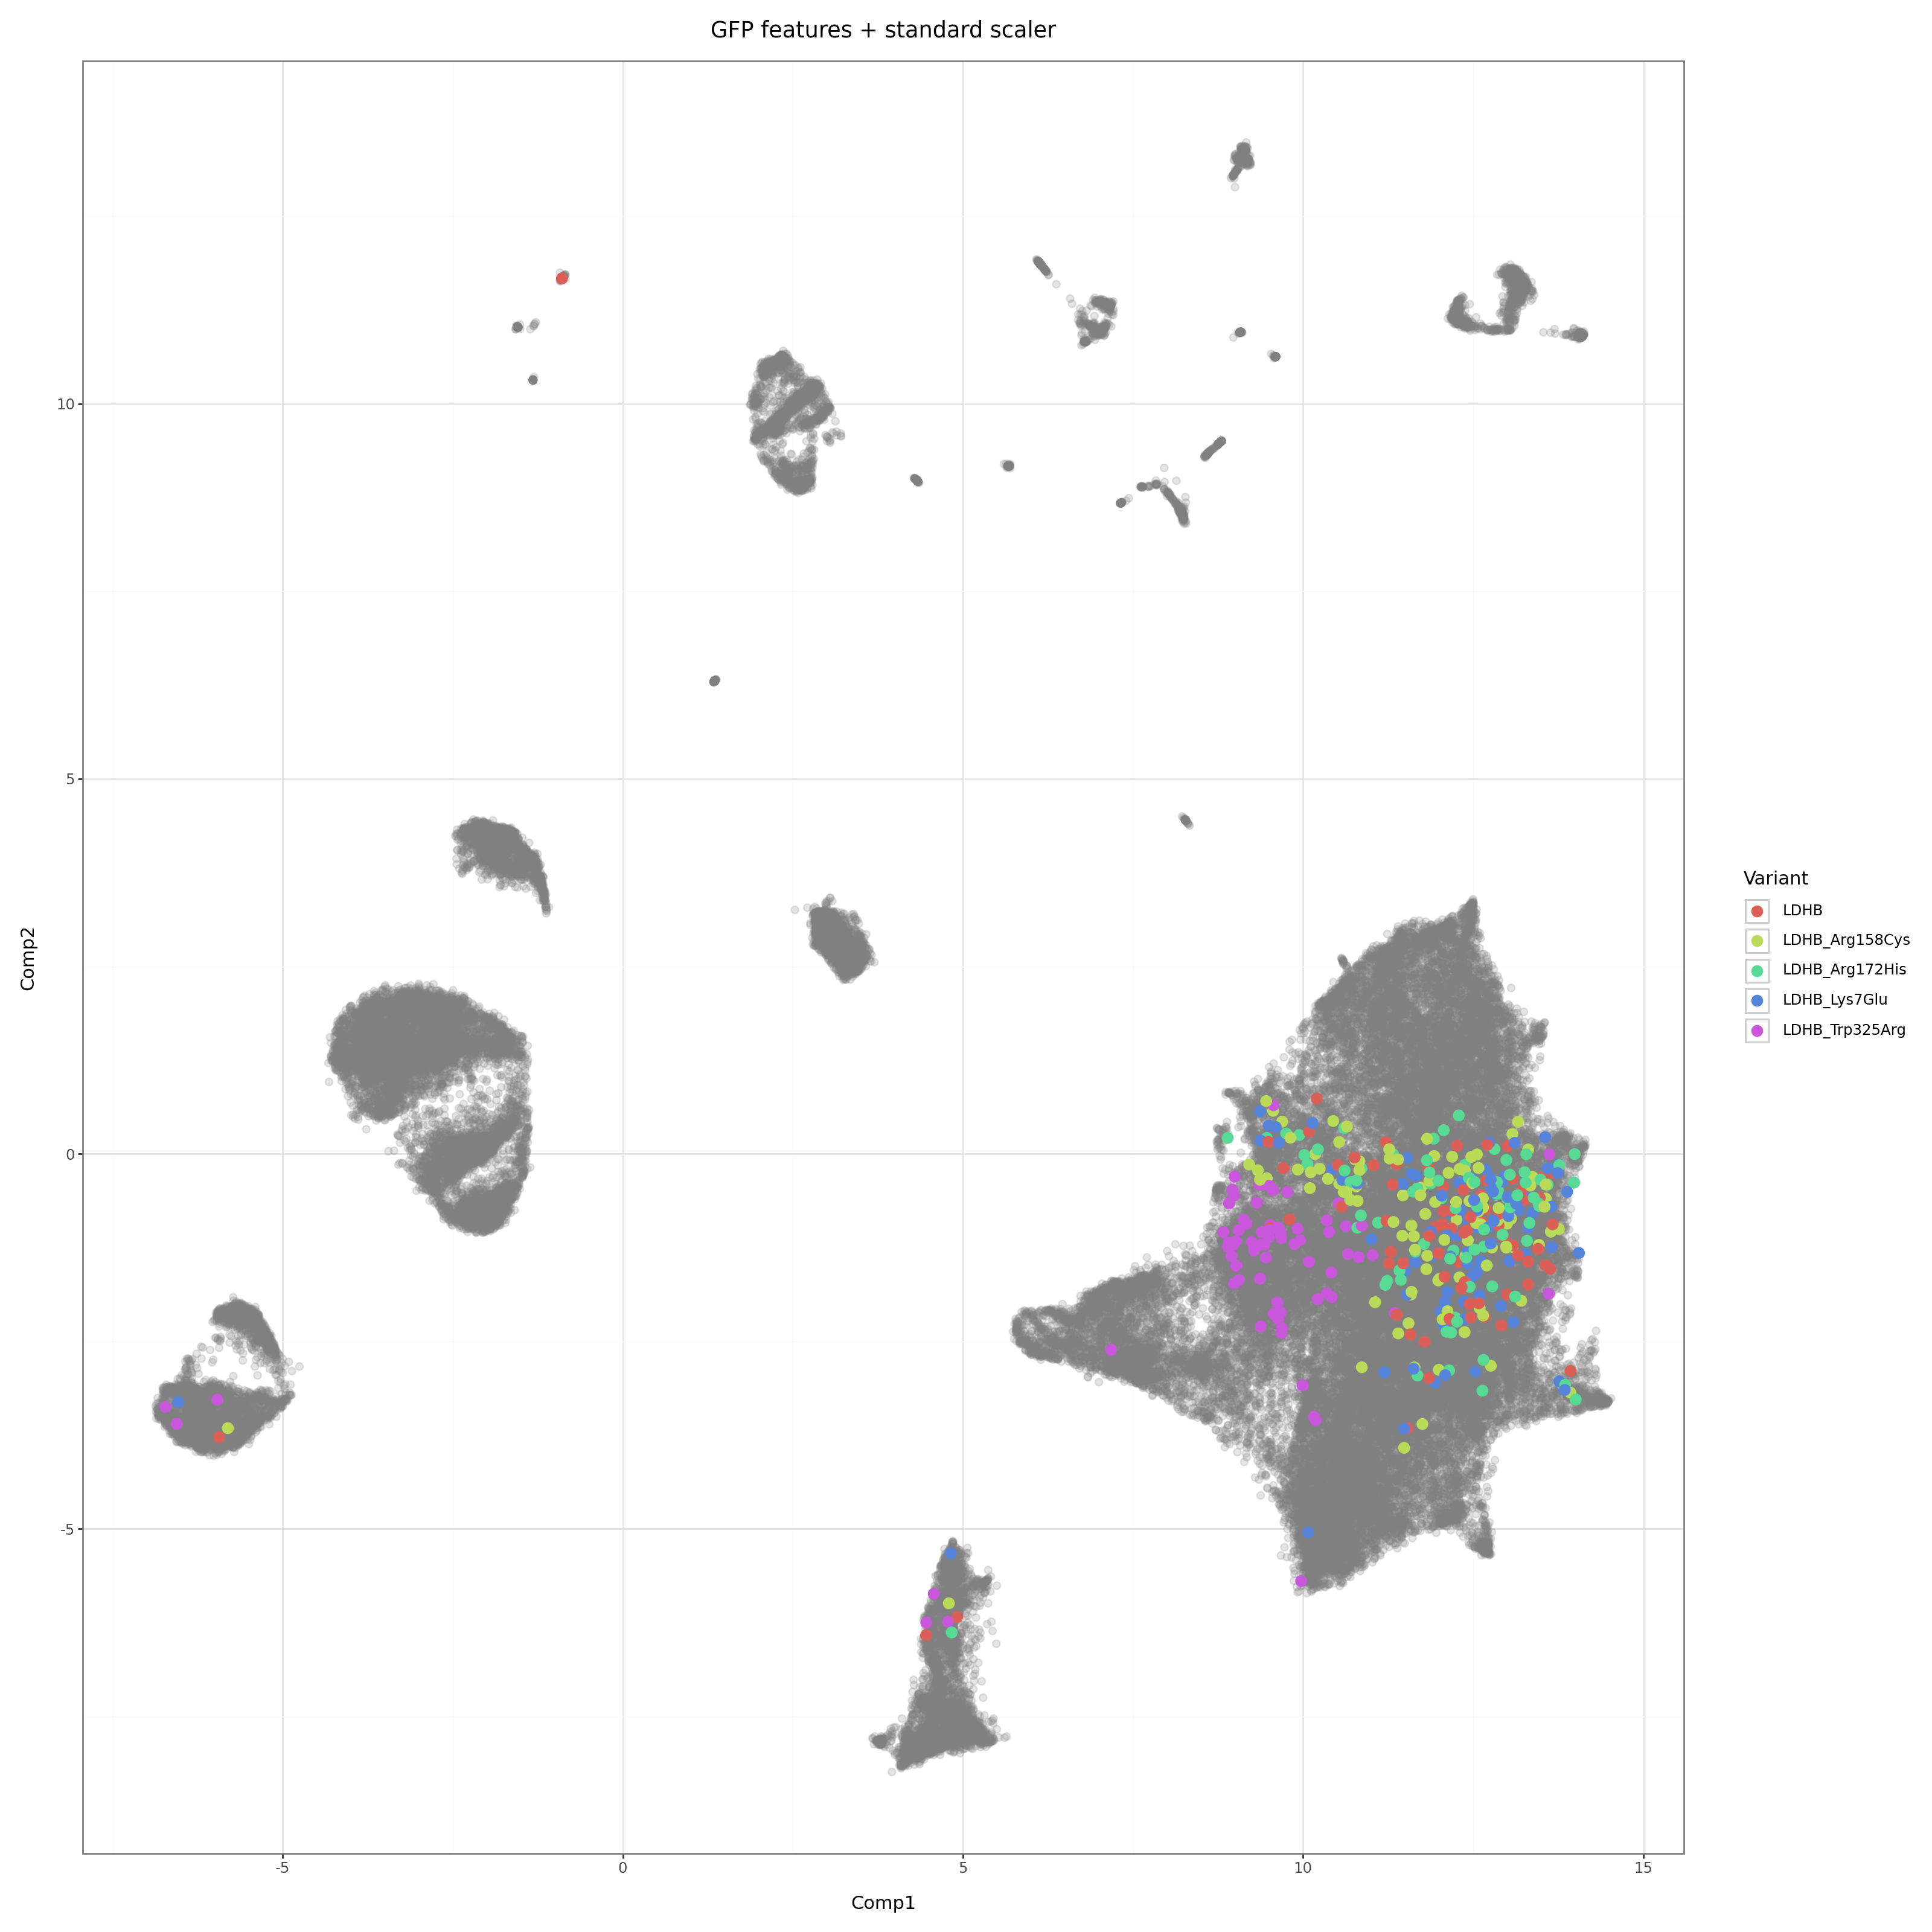

In [42]:
gene = "LDHB"
umap_gss = umap_gss.with_columns(
    pl.when(pl.col("Metadata_gene_allele").str.contains(gene))
    .then(pl.col("Metadata_gene_allele"))
    .otherwise(pl.lit("000")).alias("Variant")
).sort("Variant")

p = (ggplot() +
    geom_point(umap_gss.filter(pl.col("Variant") == "000"), aes(x = "Comp1", y = "Comp2"), color='grey',size=2, alpha=0.2) +
        geom_point(umap_gss.filter(pl.col("Variant") != "000").sample(fraction=1.0, shuffle=True), aes(x = "Comp1", y = "Comp2", color='Variant'), size=3) +
    theme_bw() + ggtitle("GFP features + standard scaler")
    )
p.show()